# Notebook TP Apprentissage Supervisé

## Étudiants
* **William CHAZOT** (p1603066)
* **Thomas BOFFY** (p1606662)

In [1]:
import warnings
warnings.filterwarnings('ignore')
import joblib

import numpy as np
np.set_printoptions(threshold=10000, suppress=True)
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, AdaBoostClassifier
from sklearn.model_selection import GridSearchCV, KFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import GaussianNB
from sklearn.impute import SimpleImputer
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from time import time

## I. Apprentissage supervisé : Feature engineering et Classification

### 1. Chargement des données et préparation

In [2]:
scoring_data = pd.read_csv("./credit_scoring.csv", sep=";")
scoring_data.head()

Seniority  Home  Time   Age  Marital  Records  Job  Expenses  Income  \
0        9.0   1.0  60.0  30.0      0.0      1.0  1.0      73.0   129.0   
1       17.0   1.0  60.0  58.0      1.0      1.0  0.0      48.0   131.0   
2       10.0   0.0  36.0  46.0      0.0      2.0  1.0      90.0   200.0   
3        0.0   1.0  60.0  24.0      1.0      1.0  0.0      63.0   182.0   
4        0.0   1.0  36.0  26.0      1.0      1.0  0.0      46.0   107.0   

   Assets  Debt  Amount   Price  Status  
0     0.0   0.0   800.0   846.0       1  
1     0.0   0.0  1000.0  1658.0       1  
2  3000.0   0.0  2000.0  2985.0       0  
3  2500.0   0.0   900.0  1325.0       1  
4     0.0   0.0   310.0   910.0       1

In [3]:
scoring_data.shape

(4375, 14)

Nous avons un jeu de données contenant 4375 individus, chacun ayant 14 variables (13 caractéristiques et 1 statut).

In [4]:
scoring_x = scoring_data.iloc[:, :13].values
scoring_y = scoring_data.iloc[:, 13].values

In [5]:
bad = 100 * np.sum(scoring_y == 0) / len(scoring_y)
good = 100 * np.sum(scoring_y == 1) / len(scoring_y)

"Bon payeurs : {0:.2f}%, Mauvais payeurs : {1:.2f}%".format(good, bad)

'Bon payeurs : 72.21%, Mauvais payeurs : 27.79%'

array([[<AxesSubplot:title={'center':'Seniority'}>,
        <AxesSubplot:title={'center':'Home'}>,
        <AxesSubplot:title={'center':'Time'}>,
        <AxesSubplot:title={'center':'Age'}>],
       [<AxesSubplot:title={'center':'Marital'}>,
        <AxesSubplot:title={'center':'Records'}>,
        <AxesSubplot:title={'center':'Job'}>,
        <AxesSubplot:title={'center':'Expenses'}>],
       [<AxesSubplot:title={'center':'Income'}>,
        <AxesSubplot:title={'center':'Assets'}>,
        <AxesSubplot:title={'center':'Debt'}>,
        <AxesSubplot:title={'center':'Amount'}>],
       [<AxesSubplot:title={'center':'Price'}>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>]], dtype=object)

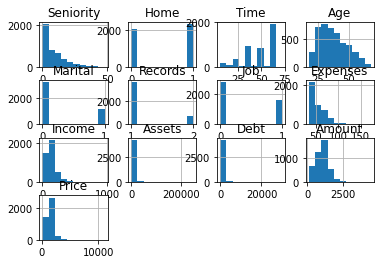

In [6]:
scoring_data.iloc[:, :13].hist()

<AxesSubplot:>

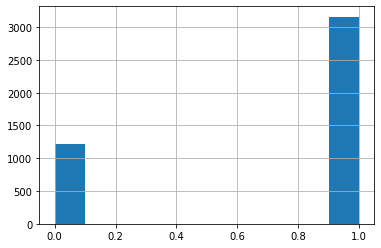

In [7]:
scoring_data.iloc[:, 13].hist()

Nous avons bien des mauvais (28%) comme de bons payeurs (72%).

In [8]:
x_train, x_test, y_train, y_test = train_test_split(scoring_x, scoring_y, test_size=0.5, random_state=1)

### 2. Apprentissage et évaluation de modèles

In [9]:
def classifier(x_train, x_test, y_train, y_test):
    # DecisionTreeClassifier
    dt = DecisionTreeClassifier(criterion="gini", random_state=1).fit(x_train, y_train)
    y_dt = dt.predict(x_test)
    
    print(confusion_matrix(y_test, y_dt))
    print("Accuracy_dt = {0:.2f}%".format(100 * accuracy_score(y_test, y_dt)))
    print("Precision_dt = {0:.2f}%".format(100 * precision_score(y_test, y_dt)))
    print("------------------------")
    
    # KNeighborsClassifier
    knn = KNeighborsClassifier(n_neighbors=5).fit(x_train, y_train)
    y_knn = knn.predict(x_test)
    
    print(confusion_matrix(y_test, y_knn))
    print("Accuracy_knn = {0:.2f}%".format(100 * accuracy_score(y_test, y_knn)))
    print("Precision_knn = {0:.2f}%".format(100 * precision_score(y_test, y_knn)))
    print("------------------------")
    
    # MLPClassifier
    mlp = MLPClassifier(hidden_layer_sizes=(40, 20), random_state=1).fit(x_train, y_train)
    y_mlp = mlp.predict(x_test)
    
    print(confusion_matrix(y_test, y_mlp))
    print("Accuracy_mlp = {0:.2f}%".format(100 * accuracy_score(y_test, y_mlp)))
    print("Precision_mlp = {0:.2f}%".format(100 * precision_score(y_test, y_mlp)))
    print("------------------------")

In [10]:
classifier(x_train, x_test, y_train, y_test)

[[ 325  279]
 [ 318 1266]]
Accuracy_dt = 72.71%
Precision_dt = 81.94%
------------------------
[[ 189  415]
 [ 187 1397]]
Accuracy_knn = 72.49%
Precision_knn = 77.10%
------------------------
[[ 167  437]
 [ 222 1362]]
Accuracy_mlp = 69.88%
Precision_mlp = 75.71%
------------------------


Ici, nous voulons nous assurer que celui qui nous paye le fasse vraiment. La **précision** est donc le critère le plus adéquat, car on veut essayer de réduire un maximum le nombre de faux positifs (les mauvais payeurs que le système a jugé comme étant de bons payeurs). L'objectif sera donc d'obtenir une précision la plus élevée.

Les résultats des différentes méthodes sont plutôt similaires, à quelques pourcents près. Il faudrait normaliser les données pour pouvoir effectuer un réelle comparaison, ce que nous allons faire par la suite.

### 3. Normalisation des variables continues

In [11]:
mms = MinMaxScaler().fit(x_train)

x_train_norm = mms.transform(x_train)
x_test_norm = mms.transform(x_test)

classifier(x_train_norm, x_test_norm, y_train, y_test)

[[ 325  279]
 [ 315 1269]]
Accuracy_dt = 72.85%
Precision_dt = 81.98%
------------------------
[[ 283  321]
 [ 236 1348]]
Accuracy_knn = 74.54%
Precision_knn = 80.77%
------------------------
[[ 321  283]
 [ 179 1405]]
Accuracy_mlp = 78.88%
Precision_mlp = 83.23%
------------------------


In [12]:
ss = StandardScaler().fit(x_train)

x_train_norm = ss.transform(x_train)
x_test_norm = ss.transform(x_test)

classifier(x_train_norm, x_test_norm, y_train, y_test)

[[ 322  282]
 [ 315 1269]]
Accuracy_dt = 72.71%
Precision_dt = 81.82%
------------------------
[[ 286  318]
 [ 223 1361]]
Accuracy_knn = 75.27%
Precision_knn = 81.06%
------------------------
[[ 342  262]
 [ 227 1357]]
Accuracy_mlp = 77.65%
Precision_mlp = 83.82%
------------------------


En comparant les 3 classifieurs sur des données normalisées, on remarque que cela *ne change rien pour le DecisionTree*, mais que cela impacte les 2 autres. En particulier, on observe un *gain conséquent de 10% sur la précision pour le classifieur MLP*, ce qui est véritablement mieux.

De plus, on remarque que les 2 normaliseurs n'apportent pas de résultats significativement différents.

### 4. Création de nouvelles variables caractéristiques par combinaisons linéaires des variables initiales

In [13]:
pca = PCA(n_components=3).fit(x_train_norm)

x_train_pca = pca.transform(x_train_norm)
x_train_pca = np.concatenate((x_train_norm, x_train_pca), axis=1)

x_test_pca = pca.transform(x_test_norm)
x_test_pca = np.concatenate((x_test_norm, x_test_pca), axis=1)

classifier(x_train_pca, x_test_pca, y_train, y_test)

[[ 351  253]
 [ 324 1260]]
Accuracy_dt = 73.63%
Precision_dt = 83.28%
------------------------
[[ 283  321]
 [ 212 1372]]
Accuracy_knn = 75.64%
Precision_knn = 81.04%
------------------------
[[ 318  286]
 [ 217 1367]]
Accuracy_mlp = 77.01%
Precision_mlp = 82.70%
------------------------


On constate que l'analyse en composantes principales (ACP) *n'est pas bénéfique pour le MLP*, mais qu'il *l'est en revanche pour le DecisionTree*.

### 5. Sélection de variables

In [14]:
clf = RandomForestClassifier(n_estimators=100, random_state=1).fit(x_train_pca, y_train)
importances = clf.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf.estimators_], axis=0)

sorted_idx = np.argsort(importances)[::-1]

features = np.concatenate((scoring_data.columns[:13], ["PCA1", "PCA2", "PCA3"]))
features[sorted_idx]

array(['Income', 'Seniority', 'PCA2', 'PCA3', 'Price', 'PCA1', 'Amount',
       'Age', 'Records', 'Assets', 'Expenses', 'Job', 'Time', 'Debt',
       'Home', 'Marital'], dtype=object)

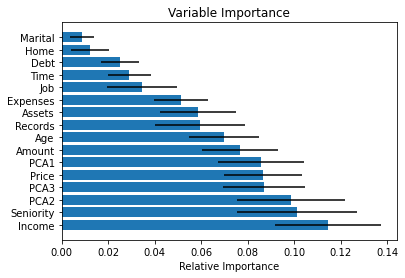

In [15]:
padding = np.arange(x_train_pca.size / len(x_train_pca)) + 0.5
plt.barh(padding, importances[sorted_idx], xerr=std[sorted_idx], align="center")
plt.yticks(padding, features[sorted_idx])
plt.xlabel("Relative Importance")
plt.title("Variable Importance")
plt.show()

In [16]:
mlp = MLPClassifier(hidden_layer_sizes=(40, 20), random_state=1)

scores_ac, scores_pr = np.zeros(x_train_pca.shape[1] + 1), np.zeros(x_train_pca.shape[1] + 1)
for f in np.arange(0, x_train_pca.shape[1] + 1):
    x1_f = x_train_pca[:,sorted_idx[:f+1]]
    x2_f = x_test_pca[:,sorted_idx[:f+1]]
    mlp.fit(x1_f, y_train)
    y_mlp = mlp.predict(x2_f)
    scores_ac[f] = np.round(accuracy_score(y_test, y_mlp), 3)
    scores_pr[f] = np.round(precision_score(y_test, y_mlp), 3)

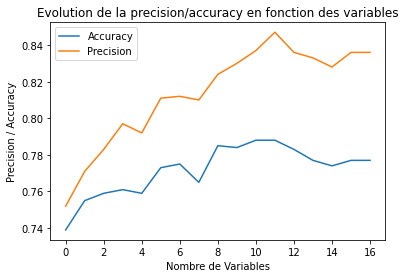

In [17]:
_, ax = plt.subplots()
    
ax.plot(scores_ac, label="Accuracy")
ax.plot(scores_pr, label="Precision")
ax.legend()

plt.xlabel("Nombre de Variables")
plt.ylabel("Precision / Accuracy")
plt.title("Evolution de la precision/accuracy en fonction des variables")

plt.show()

Pour un classifieur MLP avec deux couches cachées de taille respectives 40 et 20 neurones, dont les données ont été normalisées (standard), sur lesquelles a été appliqué un ACP et un Random Forest, on remarque que le *nombre de variables pertinentes* est de :
- 8 pour l'accuracy
- 11 pour la precision (critère que l'on souhaite maximiser ici)

Ainsi, afin d'avoir un compromis satisfaisant, nous avons choisi de prendre **10 variables**.

### 6. Paramétrage des classifieurs

In [18]:
best_var_number = 10
model = MLPClassifier(random_state=1)
parameters = {
    "hidden_layer_sizes": [(30, 10)]
}

grid_search = GridSearchCV(model, parameters, scoring=("precision", "accuracy"), refit="precision", cv=10).fit(x_train_pca[:, sorted_idx[:best_var_number]], y_train)

In [19]:
print("Mean Accuracy: {0:.3f}".format(grid_search.cv_results_["mean_test_accuracy"][0]))
print("Mean precision: {0:.3f}".format(grid_search.cv_results_["mean_test_precision"][0]))

Mean Accuracy: 0.778
Mean precision: 0.821


In [20]:
y_mlp_o = grid_search.predict(x_test_pca[:, sorted_idx[:best_var_number]])

In [21]:
print("Accuracy: {0:.3f}".format(accuracy_score(y_test, y_mlp_o)))
print("Precision: {0:.3f}".format(precision_score(y_test, y_mlp_o)))

Accuracy: 0.787
Precision: 0.839


Nous avons fait varier la valeur de certains hyperparamètres :
- *La tailles des couches cachées* : Nous avons testé de n'utiliser qu'une seule couche, comme avec un plus grand nombre (3 couches et plus), mais cela n'était pas concluant, car réduisant bien trop l'accuracy. Afin d'obtenir de meilleurs résultats, il est intéressant de réduire le nombre de neurones sur les dernières couches du réseau, soit **30 puis 10**.
- *Le solveur* : Aucun des solveurs autres qu'**Adam** (celui par défaut) ne permet d'obtenir de bons résultats.
- *la fonction d'activation* : Seul **ReLU** (celle par défaut), qui possède un intervalle infini (contrairement aux autres méthodes) permet d'obtenir de bons résultats.

### 7. Création d’un pipeline

In [22]:
p = Pipeline([
    ("scaler", StandardScaler()),
    ("pca", PCA(n_components=3)),
    ("classifier", MLPClassifier(hidden_layer_sizes=(30, 10), random_state=1))
])

# reduce the number of variables
retained_idx = sorted_idx[sorted_idx < best_var_number]

# save the pipeline in pickle file
p.fit(x_train[:, retained_idx[:best_var_number]], y_train)
joblib.dump(p, "pipeline_part_1.pkl")

['pipeline_part_1.pkl']

In [23]:
# load the pipeline from pickle file
p = joblib.load("pipeline_part_1.pkl")
"Accuracy: {0:.3f}".format(p.score(x_test[:, retained_idx[:best_var_number]], y_test))

'Accuracy: 0.771'

### 8. Comparaison de plusieurs algorithmes d’apprentissage

In [24]:
def run_classifiers(classifiers, x, y):
    kf = KFold(n_splits=10, shuffle=True, random_state=0)
    for i in clfs:
        start_time = time()
        clf = clfs[i]
        cv_acc = cross_val_score(clf, x, y, cv=kf, scoring="accuracy")
        cv_pre = cross_val_score(clf, x, y, cv=kf, scoring="precision")
        cv_rec = cross_val_score(clf, x, y, cv=kf, scoring="recall")
        cv_auc = cross_val_score(clf, x, y, cv=kf, scoring="roc_auc")
        elapsed_time = time() - start_time
        print("Accuracy for \033[1m{0}\033[0m is: {1:.3f} +/- {2:.3f} (in {3:.2f}s)".format(i, np.mean(cv_acc), np.std(cv_acc), elapsed_time))
        print("Precision for \033[1m{0}\033[0m is: {1:.3f} +/- {2:.3f}".format(i, np.mean(cv_pre), np.std(cv_pre)))
        print("Recall for \033[1m{0}\033[0m is: {1:.3f} +/- {2:.3f}".format(i, np.mean(cv_rec), np.std(cv_rec)))
        print("AUC for \033[1m{0}\033[0m is: {1:.3f} +/- {2:.3f}".format(i, np.mean(cv_auc), np.std(cv_auc)))
        print("------------------------")

clfs = {
    "NB": GaussianNB(),
    "CART": DecisionTreeClassifier(),
    "ID3": DecisionTreeClassifier(criterion="entropy"),
    "ST": DecisionTreeClassifier(max_depth=1),
    "MLP": MLPClassifier(hidden_layer_sizes=(20, 10), max_iter=200, alpha=0.001),
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "BAG": BaggingClassifier(n_estimators=50),
    "ADA": AdaBoostClassifier(n_estimators=50),
    "RF": RandomForestClassifier(n_estimators=50)
}

In [25]:
x_norm = StandardScaler().fit_transform(x_train_pca[:, sorted_idx[:best_var_number]])
run_classifiers(clfs, x_norm, y_train)

Accuracy for NB is: 0.738 +/- 0.030 (in 0.10s)
Precision for NB is: 0.802 +/- 0.037
Recall for NB is: 0.845 +/- 0.030
AUC for NB is: 0.749 +/- 0.037
------------------------
Accuracy for CART is: 0.716 +/- 0.025 (in 0.51s)
Precision for CART is: 0.798 +/- 0.036
Recall for CART is: 0.803 +/- 0.022
AUC for CART is: 0.637 +/- 0.036
------------------------
Accuracy for ID3 is: 0.706 +/- 0.022 (in 0.73s)
Precision for ID3 is: 0.788 +/- 0.025
Recall for ID3 is: 0.793 +/- 0.031
AUC for ID3 is: 0.628 +/- 0.032
------------------------
Accuracy for ST is: 0.721 +/- 0.028 (in 0.13s)
Precision for ST is: 0.736 +/- 0.030
Recall for ST is: 0.956 +/- 0.058
AUC for ST is: 0.617 +/- 0.034
------------------------
Accuracy for MLP is: 0.780 +/- 0.031 (in 39.48s)
Precision for MLP is: 0.816 +/- 0.037
Recall for MLP is: 0.891 +/- 0.022
AUC for MLP is: 0.817 +/- 0.028
------------------------
Accuracy for KNN is: 0.754 +/- 0.030 (in 0.68s)
Precision for KNN is: 0.800 +/- 0.037
Recall for KNN is: 0.879 +/

Comme précisé en début du TP, ce qui nous intéresse ici est la **précision** car nous ne voulons pas que le système considère les mauvais payeurs comme étant de bons payeurs.

De plus, comme nous l'avions envisagé, on constate que le *MLP est bien meilleur* que tous les autres classifieurs sur ce jeu de données. Cependant, **l'algorithme AdaBoost** le talonne de près et permet d'obtenir des résultats presques similaires en beaucoup moins de temps (4.69s comparé à 31.55s).

## II. Apprentissage supervisé : Données hétérogènes

### 1.1. Chargement des données et préparation

In [26]:
credit_data_original = pd.read_csv("./credit.data", sep="\t", header=None)
credit_data_original.head()

0      1      2  3  4  5  6     7  8  9   10 11 12   13   14 15
0  b  30.83  0.000  u  g  w  v  1.25  t  t   1  f  g  202    0  +
1  a  58.67  4.460  u  g  q  h  3.04  t  t   6  f  g   43  560  +
2  a  24.50  0.500  u  g  q  h  1.50  t  f   0  f  g  280  824  +
3  b  27.83  1.540  u  g  w  v  3.75  t  t   5  t  g  100    3  +
4  b  20.17  5.625  u  g  w  v  1.71  t  f   0  f  s  120    0  +

In [27]:
credit_data_original.shape

(688, 16)

In [28]:
# binarize data
credit_data_original[15].replace({"+": 1, "-": 0}, inplace=True)

credit_data = credit_data_original.copy()

# convert num values into float (and transform "?" values into NaN)
num_range = np.r_[1:3, 7, 10, 13:15]
credit_data.iloc[:, num_range] = credit_data.iloc[:, num_range].replace("?", np.nan).astype(np.float64) # shape=(688, 16)

# remove rows that contain NaN values
credit_data.dropna(inplace=True) # shape=(666, 16)
credit_data.reset_index(drop=True, inplace=True)

# divide variables into features and target
credit_x = credit_data.iloc[:, num_range].values
credit_y = credit_data.iloc[:, 15].values

In [29]:
# analyse data
good = 100 * np.sum(credit_y == 1) / len(credit_y)
bad = 100 * np.sum(credit_y == 0) / len(credit_y)

"Bon payeurs : {0:.2f}%, Mauvais payeurs : {1:.2f}%".format(good, bad)

'Bon payeurs : 44.89%, Mauvais payeurs : 55.11%'

array([[<AxesSubplot:title={'center':'1'}>,
        <AxesSubplot:title={'center':'2'}>],
       [<AxesSubplot:title={'center':'7'}>,
        <AxesSubplot:title={'center':'10'}>],
       [<AxesSubplot:title={'center':'13'}>,
        <AxesSubplot:title={'center':'14'}>]], dtype=object)

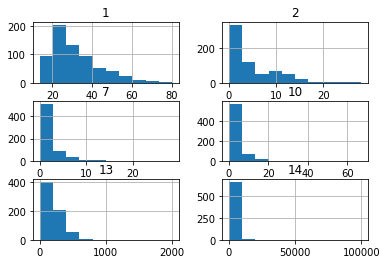

In [30]:
credit_data.iloc[:, num_range].hist()

In [31]:
x_train, x_test, y_train, y_test = train_test_split(credit_x, credit_y, test_size=0.5, random_state=1)
run_classifiers(clfs, x_train, y_train)

Accuracy for NB is: 0.730 +/- 0.072 (in 0.10s)
Precision for NB is: 0.862 +/- 0.093
Recall for NB is: 0.512 +/- 0.092
AUC for NB is: 0.807 +/- 0.050
------------------------
Accuracy for CART is: 0.669 +/- 0.077 (in 0.11s)
Precision for CART is: 0.658 +/- 0.144
Recall for CART is: 0.633 +/- 0.050
AUC for CART is: 0.661 +/- 0.056
------------------------
Accuracy for ID3 is: 0.715 +/- 0.049 (in 0.12s)
Precision for ID3 is: 0.686 +/- 0.108
Recall for ID3 is: 0.662 +/- 0.088
AUC for ID3 is: 0.687 +/- 0.065
------------------------
Accuracy for ST is: 0.748 +/- 0.073 (in 0.08s)
Precision for ST is: 0.873 +/- 0.091
Recall for ST is: 0.555 +/- 0.134
AUC for ST is: 0.743 +/- 0.058
------------------------
Accuracy for MLP is: 0.706 +/- 0.087 (in 6.11s)
Precision for MLP is: 0.689 +/- 0.096
Recall for MLP is: 0.653 +/- 0.121
AUC for MLP is: 0.780 +/- 0.081
------------------------
Accuracy for KNN is: 0.649 +/- 0.093 (in 0.15s)
Precision for KNN is: 0.645 +/- 0.102
Recall for KNN is: 0.546 +/-

Sur ce jeu de données non normalisées, on remarque que le *DecisionStump* (DecisionTree à un niveau) a la meilleure **précision**, critère que nous voulons encore une fois maximiser ici.

On remarque également que le *Random Forest* et le *Bagging* possèdent une valeur pour **l'aire sous la courbe** assez élevée.

Cenpendant, si on s'intéresse à ces deux indices simultanément, le *Naive Bayes Simple* (Gaussian) surpasse tous les algorithmes, avec des valeurs plutôt élevées. Ce dernier semble le plus adapté en terme de performance.

### 1.2. Normalisation des variables continues

In [32]:
x_train_ss_norm = StandardScaler().fit_transform(x_train)
run_classifiers(clfs, x_train_ss_norm, y_train)

Accuracy for NB is: 0.730 +/- 0.072 (in 0.09s)
Precision for NB is: 0.862 +/- 0.093
Recall for NB is: 0.512 +/- 0.092
AUC for NB is: 0.807 +/- 0.050
------------------------
Accuracy for CART is: 0.687 +/- 0.065 (in 0.10s)
Precision for CART is: 0.651 +/- 0.148
Recall for CART is: 0.641 +/- 0.065
AUC for CART is: 0.671 +/- 0.077
------------------------
Accuracy for ID3 is: 0.715 +/- 0.059 (in 0.11s)
Precision for ID3 is: 0.679 +/- 0.115
Recall for ID3 is: 0.671 +/- 0.076
AUC for ID3 is: 0.696 +/- 0.061
------------------------
Accuracy for ST is: 0.748 +/- 0.073 (in 0.08s)
Precision for ST is: 0.873 +/- 0.091
Recall for ST is: 0.555 +/- 0.134
AUC for ST is: 0.743 +/- 0.058
------------------------
Accuracy for MLP is: 0.748 +/- 0.074 (in 9.62s)
Precision for MLP is: 0.810 +/- 0.116
Recall for MLP is: 0.689 +/- 0.111
AUC for MLP is: 0.837 +/- 0.061
------------------------
Accuracy for KNN is: 0.706 +/- 0.061 (in 0.15s)
Precision for KNN is: 0.758 +/- 0.134
Recall for KNN is: 0.561 +/-

In [33]:
x_train_mms_norm = MinMaxScaler().fit_transform(x_train)
run_classifiers(clfs, x_train_mms_norm, y_train)

Accuracy for NB is: 0.730 +/- 0.072 (in 0.10s)
Precision for NB is: 0.862 +/- 0.093
Recall for NB is: 0.512 +/- 0.092
AUC for NB is: 0.807 +/- 0.050
------------------------
Accuracy for CART is: 0.679 +/- 0.058 (in 0.12s)
Precision for CART is: 0.647 +/- 0.153
Recall for CART is: 0.644 +/- 0.072
AUC for CART is: 0.653 +/- 0.073
------------------------
Accuracy for ID3 is: 0.699 +/- 0.062 (in 0.12s)
Precision for ID3 is: 0.678 +/- 0.119
Recall for ID3 is: 0.659 +/- 0.099
AUC for ID3 is: 0.703 +/- 0.056
------------------------
Accuracy for ST is: 0.748 +/- 0.073 (in 0.08s)
Precision for ST is: 0.873 +/- 0.091
Recall for ST is: 0.555 +/- 0.134
AUC for ST is: 0.743 +/- 0.058
------------------------
Accuracy for MLP is: 0.754 +/- 0.066 (in 9.72s)
Precision for MLP is: 0.798 +/- 0.109
Recall for MLP is: 0.628 +/- 0.101
AUC for MLP is: 0.825 +/- 0.048
------------------------
Accuracy for KNN is: 0.724 +/- 0.060 (in 0.15s)
Precision for KNN is: 0.809 +/- 0.134
Recall for KNN is: 0.556 +/-

Après analyse, on constate que les deux algorithmes *les plus impactées par la normalisation sont MLP et KNN*. Qu'importe le type de normaliseur utilisé (standard ou minmax), leur valeur de précision, d'accuracy et roc semble fortement augmenter.

Cependant, on observe MLP semble mieux se coupler avec un normaliseur standard, et KNN avec minmax.

### 2.1. Traitement de données manquantes

In [34]:
credit_data_np = credit_data_original.to_numpy()

# impute for categorial variables
cat_range = np.r_[0, 3:7, 8:10, 11:13]

x_cat = np.copy(credit_data_np[:, cat_range])
for col_id in range(len(cat_range)):
    _, val_idx = np.unique(x_cat[:, col_id], return_inverse=True)
    x_cat[:, col_id] = val_idx

imp_cat = SimpleImputer(missing_values=0, strategy="most_frequent")
x_cat = imp_cat.fit_transform(x_cat)

x_cat.shape

(688, 9)

In [35]:
# impute for continuous variables
x_num = np.copy(credit_data_np[:, num_range])
x_num[x_num == "?"] = np.nan
x_num = x_num.astype(float)
imp_num = SimpleImputer(missing_values=np.nan, strategy="mean")
x_num = imp_num.fit_transform(x_num)

x_num.shape

(688, 6)

### 2.2. Traitement de variables catégorielles

In [36]:
x_cat_bin = OneHotEncoder().fit_transform(x_cat).toarray()

x_cat_bin.shape

(688, 36)

### 2.3. Construction de nouveau jeu de données

In [37]:
credit_data_np = np.concatenate((x_num, x_cat_bin), axis=1)
credit_data_np.shape

(688, 42)

In [38]:
credit_y = credit_data_original.iloc[:, 15].values

In [39]:
credit_x_ss_norm = StandardScaler().fit_transform(credit_data_np)
run_classifiers(clfs, credit_x_ss_norm, credit_y)

Accuracy for NB is: 0.627 +/- 0.059 (in 0.10s)
Precision for NB is: 0.797 +/- 0.158
Recall for NB is: 0.291 +/- 0.196
AUC for NB is: 0.777 +/- 0.055
------------------------
Accuracy for CART is: 0.712 +/- 0.053 (in 0.21s)
Precision for CART is: 0.663 +/- 0.101
Recall for CART is: 0.655 +/- 0.093
AUC for CART is: 0.701 +/- 0.062
------------------------
Accuracy for ID3 is: 0.711 +/- 0.046 (in 0.23s)
Precision for ID3 is: 0.667 +/- 0.077
Recall for ID3 is: 0.655 +/- 0.126
AUC for ID3 is: 0.706 +/- 0.068
------------------------
Accuracy for ST is: 0.746 +/- 0.034 (in 0.09s)
Precision for ST is: 0.865 +/- 0.059
Recall for ST is: 0.501 +/- 0.101
AUC for ST is: 0.719 +/- 0.045
------------------------
Accuracy for MLP is: 0.756 +/- 0.051 (in 19.29s)
Precision for MLP is: 0.752 +/- 0.070
Recall for MLP is: 0.673 +/- 0.097
AUC for MLP is: 0.831 +/- 0.057
------------------------
Accuracy for KNN is: 0.688 +/- 0.047 (in 0.18s)
Precision for KNN is: 0.697 +/- 0.073
Recall for KNN is: 0.523 +/

In [40]:
credit_x_mm_norm = MinMaxScaler().fit_transform(credit_data_np)
run_classifiers(clfs, credit_x_mm_norm, credit_y)

Accuracy for NB is: 0.646 +/- 0.062 (in 0.10s)
Precision for NB is: 0.792 +/- 0.144
Recall for NB is: 0.343 +/- 0.154
AUC for NB is: 0.777 +/- 0.055
------------------------
Accuracy for CART is: 0.701 +/- 0.055 (in 0.20s)
Precision for CART is: 0.672 +/- 0.077
Recall for CART is: 0.689 +/- 0.085
AUC for CART is: 0.687 +/- 0.067
------------------------
Accuracy for ID3 is: 0.705 +/- 0.056 (in 0.22s)
Precision for ID3 is: 0.696 +/- 0.083
Recall for ID3 is: 0.652 +/- 0.105
AUC for ID3 is: 0.717 +/- 0.057
------------------------
Accuracy for ST is: 0.746 +/- 0.034 (in 0.09s)
Precision for ST is: 0.865 +/- 0.059
Recall for ST is: 0.501 +/- 0.101
AUC for ST is: 0.719 +/- 0.045
------------------------
Accuracy for MLP is: 0.756 +/- 0.055 (in 17.80s)
Precision for MLP is: 0.763 +/- 0.106
Recall for MLP is: 0.612 +/- 0.099
AUC for MLP is: 0.810 +/- 0.056
------------------------
Accuracy for KNN is: 0.670 +/- 0.033 (in 0.19s)
Precision for KNN is: 0.656 +/- 0.036
Recall for KNN is: 0.535 +/

En appliquant les classifieurs sur ces nouvelles données, comme précédemment nous obtenons *des résultats intéressants avec MLP et KNN*. Mais cette fois, les deux semblent mieux se coupler avec le *normaliseur standard* qu'avec minmax.

## III. Apprentissage supervisé sur des données textuelles : Feature engineering et Classification

### 1. Chargement des données et préparation

In [41]:
sms_spam_data = pd.read_csv("./SMSSpamCollection.data", sep="\t", header=None)
sms_spam_data.head()

0                                                  1
0   ham  Go until jurong point, crazy.. Available only ...
1   ham                      Ok lar... Joking wif u oni...
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...
3   ham  U dun say so early hor... U c already then say...
4   ham  Nah I don't think he goes to usf, he lives aro...

In [42]:
sms_spam_data[0].replace({"spam": 1, "ham": 0}, inplace=True)

sms_spam_x = sms_spam_data.iloc[:, 1].values
sms_spam_y = sms_spam_data.iloc[:, 0].values

### 2. CountVectorizer

In [55]:
vectorizer = CountVectorizer(stop_words="english", min_df=30)
occur_matrix_x = vectorizer.fit_transform(sms_spam_x).toarray()

occur_matrix_x

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [56]:
# run_classifiers(clfs, occur_matrix_x, sms_spam_y)

Dans la suite du notebook, afin de vous éviter d'exécuter le *run_classifiers* qui peut prendre énormément de temps (voyez les temps ci-dessous), nous avons écrit en textes bruts les résultats.

La **précision comme le rappel** sont importants ici, car on ne désire à la fois pas bloquer les hams, ou laisser passer de spams. C'est pourquoi nous nous concentrerons sur **l'accuracy** ici, performance globale du système.

Ainsi, en ne conservant que les termes à une **fréquence minimum de 30**, nous obtenons d'excellentes performances avec la plupart des algorithmes, sauf avec *DecisionStump* (accuracy très faible) ou *NaiveBayesSimple* (auc très faible). Les meilleurs, quant à eux, semblent être *MLP*, *Random Forest*, *AdaBoost* ou encore *Bagging*.

### 3. Tf-idf term weighting

In [45]:
transformer = TfidfTransformer(smooth_idf=False)
tfidf_x = transformer.fit_transform(occur_matrix_x).toarray()

tfidf_x

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [46]:
# run_classifiers(clfs, tfidf_x, sms_spam_y)

Après comparaison avec l'étape précédente, la phase de pondération n'apporte que peu de différences, sauf pour *NaiveBayesSimple* qui gagne un peu en performance (mais reste assez mauvais).

### 4. TruncatedSVD

In [47]:
svd = TruncatedSVD(n_components=100, random_state=1)
svd_x = svd.fit_transform(tfidf_x)

svd_x

array([[ 0.11220449, -0.03963418, -0.05860435, ...,  0.0094404 ,
        -0.00993462, -0.02968871],
       [ 0.18561726, -0.34861777,  0.38114744, ..., -0.061798  ,
        -0.014933  ,  0.03885691],
       [ 0.09311415, -0.0467985 , -0.12053894, ...,  0.02928699,
         0.01983371,  0.00744855],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.19528157, -0.03706142, -0.13327378, ..., -0.004599  ,
        -0.01087192, -0.00675296],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

In [48]:
# run_classifiers(clfs, svd_x, sms_spam_y)

Comme avec l'étape précédente, la plupart des algorithmes sont très peu impactés par cette phase de réduction, et permet à *NaiveBayesSimple* de gagner toujours un peu plus en terme de performance. En revanche, ceci est drastiquement différent pour le *DecisionStump* : il gagne énormément en auc, mais perd complètement sa précision, ce qui le rend finalement vraiment mauvais.

### 5. Pipeline

In [49]:
p_text_mining = Pipeline([
  ("Count Vectorizer", vectorizer),
  ("Tf–idf term weighting", transformer),
  ("TruncatedSVD", svd)
])

### 6. Test sur un autre jeu de données

In [50]:
yelp_data = pd.read_csv("./yelp-text-by-stars.csv", sep=None).sample(5000)
yelp_data.head()

Stars                                               Text
29746      5  I needed to get my tires replaced and didn't k...
39553      5  I usually don't write reviews, but I was very ...
7915       2  Weak Mexican food. Along the lines of Chevy's....
33567      5  I've been going here for many years. I recentl...
41287      5  They have amazing honey which I bought A LOT o...

In [51]:
yelp_x = yelp_data.iloc[:, 1].values
yelp_y = yelp_data.iloc[:, 0].values

In [52]:
yelp_x_transform = p_text_mining.fit_transform(yelp_x)

In [53]:
def scorer_precision_multi(classifier, x, y):
    return precision_score(y, classifier.predict(x), average="macro")

def scorer_recall_multi(classifier, x, y):
    return recall_score(y, classifier.predict(x), average="macro")

def run_classifiers_multi(classifiers, x, y):
    kf = KFold(n_splits=10, shuffle=True, random_state=0)
    for i in clfs:
        start_time = time()
        clf = clfs[i]
        cv_acc = cross_val_score(clf, x, y, cv=kf, scoring="accuracy")
        cv_pre = cross_val_score(clf, x, y, cv=kf, scoring=scorer_precision_multi)
        cv_rec = cross_val_score(clf, x, y, cv=kf, scoring=scorer_recall_multi)
        elapsed_time = time() - start_time
        print("Accuracy for \033[1m{0}\033[0m is: {1:.3f} +/- {2:.3f} (in {3:.2f}s)".format(i, np.mean(cv_acc), np.std(cv_acc), elapsed_time))
        print("Precision for \033[1m{0}\033[0m is: {1:.3f} +/- {2:.3f}".format(i, np.mean(cv_pre), np.std(cv_pre)))
        print("Recall for \033[1m{0}\033[0m is: {1:.3f} +/- {2:.3f}".format(i, np.mean(cv_rec), np.std(cv_rec)))
        print("------------------------")

In [57]:
# run_classifiers_multi(clfs, yelp_x_transform, yelp_y)

Afin de s'adapter à ce *problème multi-classes*, nous avons réimplémenté la fonction testant les classifieurs.

Par ailleurs, le jeu de données étant vraiment très conséquent (40k lignes), nous nous sommes basés sur un *petit échantillon d'individus* (5000). Avec cette configuration, la performance pour l'ensemble des algorithmes est *globalement très mauvaise* (maximum observable à 55%), et ne change pas même avec plus d'individus.

En fait, ici l'objectif n'est pas de rechercher la solution optimale, mais tout simplement de trouver le classifieur le plus adapté, même si celui-ci n'est pas très bon. On constate donc qu'un **bon réseau de neurones profonds (MLP)** est le plus intéressant.